# Explore the outcome of a hyperparameter sweep for metric correlation between datasets

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
import seaborn as sns
import matplotlib.pyplot as plt
import sys

pd.options.display.max_colwidth = None
MODULE_PATH =  Path(os.getcwd()).parents[1].resolve()

In [3]:
%cd {MODULE_PATH}

/home/shaul/workspace/GitHub/SOTA


In [4]:
path_combined = 'combined_dataset.csv'
path_sts = 'sts.csv'
path_qqp = 'qqp.csv'
path_sample_qqp = 'sample_qqp.csv'
report_file = "wandb_total_experiment.csv"

PATH_DATA = MODULE_PATH / 'data'
PATH_COMBINED = PATH_DATA / 'datasets' / path_combined
PATH_STS = PATH_DATA / 'datasets' / path_sts
PATH_SAMPLE_QQP = PATH_DATA / 'datasets' / path_sample_qqp

In [10]:
df = pd.read_csv(PATH_DATA / 'reports' / report_file, index_col="Name")

all_metrics = df.metrics.unique()

# 0 = ALL, 1 = Top 3, 2 = Top 4
df_all_metrics = df[df.metrics == all_metrics[0]]
df_top4_metrics = df[df.metrics == all_metrics[1]]
df_top3_metrics = df[df.metrics == all_metrics[2]]
# df['RF Increase'] = df['RF PearsonR'] - df['Base Top Correlation']
# df['RF Increase Percentage'] = df['RF Increase'] / df['Base Top Correlation']

# Each metric with itself

In [12]:
df = df_all_metrics

train_dataset = path_combined
test_dataset = None
filtered = True


if filtered:
    display(df[(df['train_dataset'] == train_dataset) & (df['test_dataset'].isnull()) & (~df['bad_annotators'].isnull())] \
    .sort_values(by="RF Increase",ascending=False)[:3])
else:
    display(df[(df['train_dataset'] == train_dataset) & (df['test_dataset'].isnull()) & (df['bad_annotators'].isnull())] \
    .sort_values(by="RF Increase",ascending=False)[:3])

,bad_annotators,metrics,rf_depth,rf_top_n_features,scale_features,scale_labels,test_dataset,train_dataset,Base Top Correlation,RF PearsonR,RF Increase,RF Increase Percentage
Name,,,,,,,,,,,,
eager-energy-1342,ba_all.txt,"[""bleu"",""bleu1"",""glove_cosine"",""fasttext_cosine"",""BertScore"",""chrfScore"",""POS Dist score"",""1-gram_overlap"",""ROUGE-1"",""ROUGE-2"",""ROUGE-l"",""L2_score"",""WMD""]",8,NaN,False,False,NaN,combined_dataset.csv,0.56437,0.610011,0.045642,0.080872
chocolate-river-1293,ba_all.txt,"[""bleu"",""bleu1"",""glove_cosine"",""fasttext_cosine"",""BertScore"",""chrfScore"",""POS Dist score"",""1-gram_overlap"",""ROUGE-1"",""ROUGE-2"",""ROUGE-l"",""L2_score"",""WMD""]",6,NaN,True,False,NaN,combined_dataset.csv,0.56437,0.609950,0.045580,0.080762
grateful-totem-1328,ba_all.txt,"[""bleu"",""bleu1"",""glove_cosine"",""fasttext_cosine"",""BertScore"",""chrfScore"",""POS Dist score"",""1-gram_overlap"",""ROUGE-1"",""ROUGE-2"",""ROUGE-l"",""L2_score"",""WMD""]",6,NaN,False,False,NaN,combined_dataset.csv,0.56437,0.609875,0.045505,0.080629


In [13]:
train_dataset = path_sample_qqp

display(df[(df['train_dataset'] == train_dataset) & (df['test_dataset'].isnull())].sort_values(by="RF Increase",ascending=False)[:3])

,bad_annotators,metrics,rf_depth,rf_top_n_features,scale_features,scale_labels,test_dataset,train_dataset,Base Top Correlation,RF PearsonR,RF Increase,RF Increase Percentage
Name,,,,,,,,,,,,
silvery-butterfly-890,NaN,"[""bleu"",""bleu1"",""glove_cosine"",""fasttext_cosine"",""BertScore"",""chrfScore"",""POS Dist score"",""1-gram_overlap"",""ROUGE-1"",""ROUGE-2"",""ROUGE-l"",""L2_score"",""WMD""]",9,NaN,True,False,NaN,sample_qqp.csv,0.438372,0.565818,0.127446,0.290725
silver-dawn-945,NaN,"[""bleu"",""bleu1"",""glove_cosine"",""fasttext_cosine"",""BertScore"",""chrfScore"",""POS Dist score"",""1-gram_overlap"",""ROUGE-1"",""ROUGE-2"",""ROUGE-l"",""L2_score"",""WMD""]",9,NaN,False,False,NaN,sample_qqp.csv,0.438372,0.564425,0.126052,0.287547
denim-disco-933,NaN,"[""bleu"",""bleu1"",""glove_cosine"",""fasttext_cosine"",""BertScore"",""chrfScore"",""POS Dist score"",""1-gram_overlap"",""ROUGE-1"",""ROUGE-2"",""ROUGE-l"",""L2_score"",""WMD""]",8,NaN,False,False,NaN,sample_qqp.csv,0.438372,0.560288,0.121916,0.278111


In [14]:
train_dataset = path_sts

display(df[(df['train_dataset'] == train_dataset) & (df['test_dataset'].isnull())].sort_values(by="RF Increase",ascending=False)[:3])

,bad_annotators,metrics,rf_depth,rf_top_n_features,scale_features,scale_labels,test_dataset,train_dataset,Base Top Correlation,RF PearsonR,RF Increase,RF Increase Percentage
Name,,,,,,,,,,,,
unique-firebrand-145,NaN,"[""bleu"",""bleu1"",""glove_cosine"",""fasttext_cosine"",""BertScore"",""chrfScore"",""POS Dist score"",""1-gram_overlap"",""ROUGE-1"",""ROUGE-2"",""ROUGE-l"",""L2_score"",""WMD""]",9,NaN,False,False,NaN,sts.csv,0.707256,0.781490,0.074234,0.104961
twilight-feather-138,NaN,"[""bleu"",""bleu1"",""glove_cosine"",""fasttext_cosine"",""BertScore"",""chrfScore"",""POS Dist score"",""1-gram_overlap"",""ROUGE-1"",""ROUGE-2"",""ROUGE-l"",""L2_score"",""WMD""]",8,NaN,False,False,NaN,sts.csv,0.707256,0.780856,0.073600,0.104064
giddy-valley-110,NaN,"[""bleu"",""bleu1"",""glove_cosine"",""fasttext_cosine"",""BertScore"",""chrfScore"",""POS Dist score"",""1-gram_overlap"",""ROUGE-1"",""ROUGE-2"",""ROUGE-l"",""L2_score"",""WMD""]",9,NaN,True,False,NaN,sts.csv,0.707256,0.780600,0.073344,0.103702


## Find the cases where the RF Increase is the highest

In [15]:
df = df_all_metrics

train_dataset = path_sts
test_dataset = path_combined
filtered = False

if filtered:
    display(df[(df['train_dataset'] == train_dataset) & (df['test_dataset'] == test_dataset) & (~df['bad_annotators'].isnull())] \
    .sort_values(by="RF Increase",ascending=False)[:3])
else:
    display(df[(df['train_dataset'] == train_dataset) & (df['test_dataset'] == test_dataset) & (df['bad_annotators'].isnull())] \
    .sort_values(by="RF Increase",ascending=False)[:3])

,bad_annotators,metrics,rf_depth,rf_top_n_features,scale_features,scale_labels,test_dataset,train_dataset,Base Top Correlation,RF PearsonR,RF Increase,RF Increase Percentage
Name,,,,,,,,,,,,
solar-sponge-254,NaN,"[""bleu"",""bleu1"",""glove_cosine"",""fasttext_cosine"",""BertScore"",""chrfScore"",""POS Dist score"",""1-gram_overlap"",""ROUGE-1"",""ROUGE-2"",""ROUGE-l"",""L2_score"",""WMD""]",5,4.0,False,False,combined_dataset.csv,sts.csv,0.437099,0.429393,-0.007706,-0.017630
happy-microwave-219,NaN,"[""bleu"",""bleu1"",""glove_cosine"",""fasttext_cosine"",""BertScore"",""chrfScore"",""POS Dist score"",""1-gram_overlap"",""ROUGE-1"",""ROUGE-2"",""ROUGE-l"",""L2_score"",""WMD""]",5,4.0,True,False,combined_dataset.csv,sts.csv,0.437099,0.429289,-0.007810,-0.017867
polished-bee-261,NaN,"[""bleu"",""bleu1"",""glove_cosine"",""fasttext_cosine"",""BertScore"",""chrfScore"",""POS Dist score"",""1-gram_overlap"",""ROUGE-1"",""ROUGE-2"",""ROUGE-l"",""L2_score"",""WMD""]",6,4.0,False,False,combined_dataset.csv,sts.csv,0.437099,0.428729,-0.008370,-0.019149


## Visualize how the RF changes overall

In [16]:
df = df_all_metrics

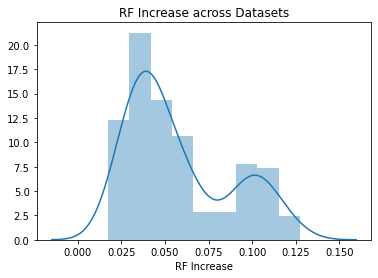

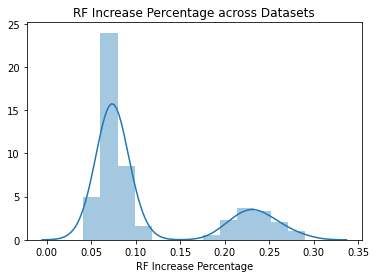

In [17]:
sns.distplot(df[(df['train_dataset'] != df['test_dataset']) & (df['test_dataset'].isna())]['RF Increase']);
plt.title("RF Increase across Datasets")
plt.show()
sns.distplot(df[(df['train_dataset'] != df['test_dataset']) & (df['test_dataset'].isna())]['RF Increase Percentage']);
plt.title("RF Increase Percentage across Datasets")
plt.show();

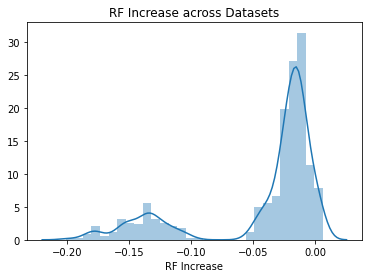

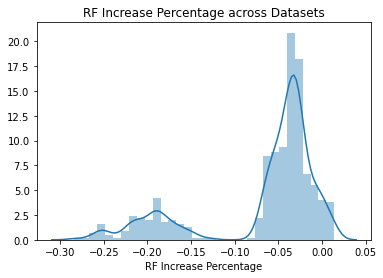

In [18]:
sns.distplot(df[(df['train_dataset'] != df['test_dataset']) & (~df['test_dataset'].isna())]['RF Increase']);
plt.title("RF Increase across Datasets")
plt.show()
sns.distplot(df[(df['train_dataset'] != df['test_dataset']) & (~df['test_dataset'].isna())]['RF Increase Percentage']);
plt.title("RF Increase Percentage across Datasets")
plt.show();

In [21]:
idx = df[df['test_dataset'].notnull()]['RF Increase'].sort_values(ascending=False)[:5].index
display(df.loc[idx])

,bad_annotators,metrics,rf_depth,rf_top_n_features,scale_features,scale_labels,test_dataset,train_dataset,Base Top Correlation,RF PearsonR,RF Increase,RF Increase Percentage
Name,,,,,,,,,,,,
zany-shadow-303,NaN,"[""bleu"",""bleu1"",""glove_cosine"",""fasttext_cosine"",""BertScore"",""chrfScore"",""POS Dist score"",""1-gram_overlap"",""ROUGE-1"",""ROUGE-2"",""ROUGE-l"",""L2_score"",""WMD""]",7,4.0,True,False,sample_qqp.csv,sts.csv,0.439459,0.445634,0.006175,0.014053
fanciful-elevator-319,NaN,"[""bleu"",""bleu1"",""glove_cosine"",""fasttext_cosine"",""BertScore"",""chrfScore"",""POS Dist score"",""1-gram_overlap"",""ROUGE-1"",""ROUGE-2"",""ROUGE-l"",""L2_score"",""WMD""]",9,6.0,True,False,sample_qqp.csv,sts.csv,0.439459,0.445626,0.006167,0.014033
upbeat-smoke-355,NaN,"[""bleu"",""bleu1"",""glove_cosine"",""fasttext_cosine"",""BertScore"",""chrfScore"",""POS Dist score"",""1-gram_overlap"",""ROUGE-1"",""ROUGE-2"",""ROUGE-l"",""L2_score"",""WMD""]",9,NaN,False,False,sample_qqp.csv,sts.csv,0.439459,0.445446,0.005987,0.013625
trim-snowball-331,NaN,"[""bleu"",""bleu1"",""glove_cosine"",""fasttext_cosine"",""BertScore"",""chrfScore"",""POS Dist score"",""1-gram_overlap"",""ROUGE-1"",""ROUGE-2"",""ROUGE-l"",""L2_score"",""WMD""]",6,4.0,False,False,sample_qqp.csv,sts.csv,0.439459,0.445258,0.005799,0.013197
effortless-music-296,NaN,"[""bleu"",""bleu1"",""glove_cosine"",""fasttext_cosine"",""BertScore"",""chrfScore"",""POS Dist score"",""1-gram_overlap"",""ROUGE-1"",""ROUGE-2"",""ROUGE-l"",""L2_score"",""WMD""]",6,4.0,True,False,sample_qqp.csv,sts.csv,0.439459,0.444659,0.005201,0.011834


## Exploring some SHAP

In [36]:
from src import model_corr
import shap
from sklearn.ensemble import RandomForestRegressor
import regex as re

In [23]:
shap.initjs()

In [44]:
metrics = all_metrics[0]
metric_list = re.sub("\"","",metrics.strip(".][")).split(",")
# metric_list[1]

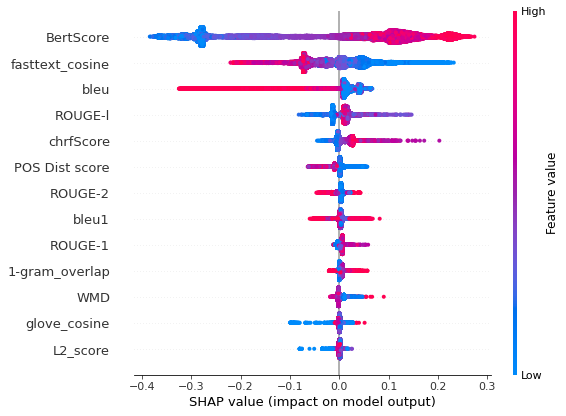

In [45]:
df = pd.read_csv(PATH_SAMPLE_QQP)
df.dropna(inplace=True)
model = RandomForestRegressor(max_depth=6)
model.fit(df[metric_list], df['label'])

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(df[metric_list])

shap.summary_plot(shap_values, df[metric_list])

## Exploring transferability from Combined to other datasets based off filtering

### On all Top N Features

In [46]:
df = df_all_metrics

In [52]:
ex1 = df[(df['train_dataset']==path_combined) & (df['test_dataset'] == path_sts) & (df['bad_annotators'].isnull())].sort_values(by="RF Increase", ascending=False).head(1)

ex2 = df[(df['train_dataset']==path_combined) & (df['test_dataset'] == path_sts) & (df['bad_annotators'].notnull())].sort_values(by="RF Increase", ascending=False).head(1)

ex3 = df[(df['train_dataset']==path_combined) & (df['test_dataset'] == path_sample_qqp) & (df['bad_annotators'].isnull())].sort_values(by="RF Increase",ascending=False).head(1)

ex4 = df[(df['train_dataset']==path_combined) & (df['test_dataset'] == path_sample_qqp) & (df['bad_annotators'].notnull())].sort_values(by="RF Increase",ascending=False).head(1)

In [53]:
pd.concat([ex1,ex2,ex3,ex4])

,bad_annotators,metrics,rf_depth,rf_top_n_features,scale_features,scale_labels,test_dataset,train_dataset,Base Top Correlation,RF PearsonR,RF Increase,RF Increase Percentage
Name,,,,,,,,,,,,
twilight-blaze-1579,NaN,"[""bleu"",""bleu1"",""glove_cosine"",""fasttext_cosine"",""BertScore"",""chrfScore"",""POS Dist score"",""1-gram_overlap"",""ROUGE-1"",""ROUGE-2"",""ROUGE-l"",""L2_score"",""WMD""]",5,NaN,True,False,sts.csv,combined_dataset.csv,0.705798,0.608587,-0.097211,-0.137732
feasible-darkness-1426,ba_all.txt,"[""bleu"",""bleu1"",""glove_cosine"",""fasttext_cosine"",""BertScore"",""chrfScore"",""POS Dist score"",""1-gram_overlap"",""ROUGE-1"",""ROUGE-2"",""ROUGE-l"",""L2_score"",""WMD""]",5,NaN,True,False,sts.csv,combined_dataset.csv,0.705798,0.583700,-0.122098,-0.172993
playful-deluge-775,NaN,"[""bleu"",""bleu1"",""glove_cosine"",""fasttext_cosine"",""BertScore"",""chrfScore"",""POS Dist score"",""1-gram_overlap"",""ROUGE-1"",""ROUGE-2"",""ROUGE-l"",""L2_score"",""WMD""]",9,NaN,False,False,sample_qqp.csv,combined_dataset.csv,0.439459,0.428105,-0.011353,-0.025834
vague-mountain-1652,ba_all.txt,"[""bleu"",""bleu1"",""glove_cosine"",""fasttext_cosine"",""BertScore"",""chrfScore"",""POS Dist score"",""1-gram_overlap"",""ROUGE-1"",""ROUGE-2"",""ROUGE-l"",""L2_score"",""WMD""]",6,3.0,True,False,sample_qqp.csv,combined_dataset.csv,0.439459,0.438420,-0.001038,-0.002362


We can see from here, that when we take all of the features, then when we remove ba, the internal scores are better, but it slightly underperforms transferability.

### What would happen if we only take Ivan's top 3 features:

In [54]:
df = df_top3_metrics

In [55]:
ex1 = df[(df['train_dataset']==path_combined) & (df['test_dataset'] == path_sts) & (df['bad_annotators'].isnull())].sort_values(by="RF Increase", ascending=False).head(1)

ex2 = df[(df['train_dataset']==path_combined) & (df['test_dataset'] == path_sts) & (df['bad_annotators'].notnull())].sort_values(by="RF Increase", ascending=False).head(1)

ex3 = df[(df['train_dataset']==path_combined) & (df['test_dataset'] == path_sample_qqp) & (df['bad_annotators'].isnull())].sort_values(by="RF Increase", ascending=False).head(1)

ex4 = df[(df['train_dataset']==path_combined) & (df['test_dataset'] == path_sample_qqp) & (df['bad_annotators'].notnull())].sort_values(by="RF Increase", ascending=False).head(1)

In [56]:
pd.concat([ex1,ex2,ex3,ex4])

,bad_annotators,metrics,rf_depth,rf_top_n_features,scale_features,scale_labels,test_dataset,train_dataset,Base Top Correlation,RF PearsonR,RF Increase,RF Increase Percentage
Name,,,,,,,,,,,,
devoted-shadow-1580,NaN,"[""WMD"",""BertScore"",""POS Dist score""]",5,NaN,True,False,sts.csv,combined_dataset.csv,0.559462,0.561040,0.001578,0.002820
dutiful-moon-1427,ba_all.txt,"[""WMD"",""BertScore"",""POS Dist score""]",5,NaN,True,False,sts.csv,combined_dataset.csv,0.559462,0.521599,-0.037863,-0.067678
wild-spaceship-1720,NaN,"[""WMD"",""BertScore"",""POS Dist score""]",5,NaN,True,False,sample_qqp.csv,combined_dataset.csv,0.439459,0.412695,-0.026764,-0.060902
playful-sun-1685,ba_all.txt,"[""WMD"",""BertScore"",""POS Dist score""]",5,NaN,False,False,sample_qqp.csv,combined_dataset.csv,0.439459,0.401525,-0.037934,-0.086320


### And when we take all 4 features

In [57]:
df = df_top4_metrics

In [58]:
ex1 = df[(df['train_dataset']==path_combined) & (df['test_dataset'] == path_sts) & (df['bad_annotators'].isnull())].sort_values(by="RF Increase", ascending=False).head(1)

ex2 = df[(df['train_dataset']==path_combined) & (df['test_dataset'] == path_sts) & (df['bad_annotators'].notnull())].sort_values(by="RF Increase", ascending=False).head(1)

ex3 = df[(df['train_dataset']==path_combined) & (df['test_dataset'] == path_sample_qqp) & (df['bad_annotators'].isnull())].sort_values(by="RF Increase", ascending=False).head(1)

ex4 = df[(df['train_dataset']==path_combined) & (df['test_dataset'] == path_sample_qqp) & (df['bad_annotators'].notnull())].sort_values(by="RF Increase", ascending=False).head(1)

In [59]:
pd.concat([ex1,ex2,ex3,ex4])

,bad_annotators,metrics,rf_depth,rf_top_n_features,scale_features,scale_labels,test_dataset,train_dataset,Base Top Correlation,RF PearsonR,RF Increase,RF Increase Percentage
Name,,,,,,,,,,,,
colorful-frog-1581,NaN,"[""WMD"",""BertScore"",""POS Dist score"",""fasttext_cosine""]",5,NaN,True,False,sts.csv,combined_dataset.csv,0.705798,0.568552,-0.137245,-0.194454
light-oath-1428,ba_all.txt,"[""WMD"",""BertScore"",""POS Dist score"",""fasttext_cosine""]",5,NaN,True,False,sts.csv,combined_dataset.csv,0.705798,0.544543,-0.161254,-0.228471
whole-dream-1721,NaN,"[""WMD"",""BertScore"",""POS Dist score"",""fasttext_cosine""]",5,NaN,True,False,sample_qqp.csv,combined_dataset.csv,0.439459,0.410235,-0.029224,-0.066499
dutiful-snowflake-1651,ba_all.txt,"[""WMD"",""BertScore"",""POS Dist score"",""fasttext_cosine""]",5,NaN,True,False,sample_qqp.csv,combined_dataset.csv,0.439459,0.392542,-0.046917,-0.106761
